In [8]:
from pysr import PySRRegressor, TemplateExpressionSpec

import matplotlib.pyplot as plt
import numpy as np

import camb

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


In [9]:
plt.rcParams['font.family'] = 'stixgeneral'

In [10]:
# Load Data
pars     = np.load('CL_data/parameter_test.npy')  # [H0, ombh2, omch2 ] x 100
lensed   = np.load('CL_data/lensed_CL.npy')     # [C_2, ..., C_5000] x 100 (lensed)
unlensed = np.load('CL_data/unlensed_CL.npy')     # [C_2, ..., C_5000] x 100 (unlensed)

In [11]:
past_ells = 1000
n_ells = 4998 - past_ells

# Truncate to ignore first 1000 l's
y_pysr = lensed[:, past_ells:]/unlensed[:, past_ells:]  #lensing

def moving_average(x):
    val = np.convolve(x, np.ones(500), 'valid') / 500
    return val

# Smoothing the Lensing Tail for Training
do_smoothing = True

if do_smoothing:
    y_pysr[:, 249:-250] = np.apply_along_axis(moving_average, axis = 1, arr = y_pysr[:, :])

# Reformatting data
y_pysr = y_pysr.reshape(-1)
# y_pysr : [par1_c502, par1_c503, ..., par1_c5000, par2_c502, ..., par299_c502, ..., par299_c5000]

In [12]:
# Reformatting data
X_ells = np.array([ell for ell in range(past_ells + 2, 5000)])
pars_pysr = pars[:]
X_pysr = np.zeros((y_pysr.shape[0], 3 + 1))  #for the three cosmo parameters plus ells

In [13]:
# Reformatting data
for i in range(100):
    X_pysr[n_ells*i:n_ells*(i+1), :3] = np.tile(pars[i], n_ells).reshape(n_ells, -1)
    X_pysr[n_ells*i:n_ells*(i+1), -1] = X_ells   #final column is ells

# make x3 = ombh2 + omch2 = om0h2
X_pysr[:, 2] = X_pysr[:, 1] + X_pysr[:, 2]  


In [14]:
ells = np.array([l for l in range(2, 5000)])

In [80]:
# Final Fit

def lensing_tail_fit0(ell, ombh2, omch2):
    beta_1, beta_2, beta_3 = [4.2051106e-5, 0.8946482, 0.15472274]
    
    x2 = ombh2 + omch2 
    x1 = ombh2

    # Sigmoid
    sigm = (1 + np.exp(-(ell-beta_3*2000)/100))**(-1)

    # Exponent
    #alpha = (ombh2**-0.877) * (ombh2 + omch2) - 3.342*(ombh2 + omch2) - 1.118
    alpha = 1.2881212 + (x2 - (x1 * 7.060776))

    # Polynomial
    poly = (beta_1*(ell/beta_2)**alpha - 1)

    L = poly*sigm + 1


    return L


In [81]:
def lensing_tail_fit1(ell, ombh2, omch2):
    beta_1, beta_2, beta_3 = [0.000109259934, 2.3817177, 0.16267268]
    
    x2 = ombh2 + omch2 
    x1 = ombh2

    # Sigmoid
    sigm = (1 + np.exp(-(ell-beta_3*2000)/200))**(-1)

    # Exponent
    #alpha = (ombh2**-0.877) * (ombh2 + omch2) - 3.342*(ombh2 + omch2) - 1.118
    alpha =  1.0369264 - ((x1 ** -0.5167298) * -0.03699228)

    # Polynomial
    poly = (beta_1*(ell/beta_2)**alpha - 1)

    L = poly*sigm + 1


    return L


In [82]:
def return_error(func):
    return [100*np.abs(func(ells, pars_pysr[ind, 1], pars_pysr[ind, 2]) - lensed[ind]/unlensed[ind])/(lensed[ind]/unlensed[ind]) for ind in range(0, 100)]

In [83]:
error0 = return_error(lensing_tail_fit0)
error1 = return_error(lensing_tail_fit1)

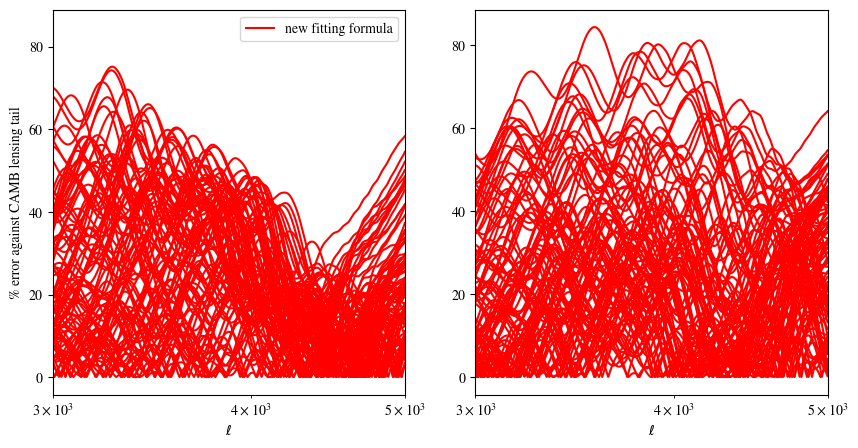

In [84]:
fig, ax = plt.subplots(1, 2, figsize = (10, 5))
# Fit % Error for 100 Cosmologies
for ind in range(0, 100):
    ax[0].semilogx(ells, error0[ind], "r", label='new fitting formula')
for ind in range(0, 100):
    ax[1].semilogx(ells, error1[ind], "r", label='new fitting formula')


for i in range(2):
    ax[i].set_xlim(3000, 5000)
    ax[i].set_xlabel("$\\ell$")

ax[0].set_ylabel("% error against CAMB lensing tail")


handles, labels = fig.gca().get_legend_handles_labels()
newLabels, newHandles = [], []
for handle, label in zip(handles, labels):
    if label not in newLabels:
        newLabels.append(label)
        newHandles.append(handle)
ax[0].legend(newHandles, newLabels)

In [85]:
def pars_of_error(perc):
    inds = []
    for i in range(len(error)):
        if np.mean(error[i]) > perc:
            inds.append(i)
    ombs = []
    omcs = []
    for i in inds:
        ombs.append(pars[i][1])
        omcs.append(pars[i][2])
    return ombs, omcs

In [86]:
#ombs20, omcs20 = pars_of_error(20)
#ombs10, omcs10 = pars_of_error(10)

fid_ombh2 = 0.0224
fid_omch2 = 0.12

In [87]:
#plt.scatter(ombs10, omcs10, color = "orange", label = "> 10% error (mean)")
#plt.scatter(ombs20, omcs20, color = "red", label = "> 20% error (mean)")
#plt.scatter(fid_ombh2, fid_omch2, color = "black", label = "Fiducial Cosmology (reference)")
#plt.legend()
#plt.xlabel("$\Omega_bh^2$")
#plt.ylabel("$\Omega_ch^2$")
#plt.show()

In [88]:
def plot_scatter(error):
    fig,ax = plt.subplots()
    for i in range(len(error)):
        a = ax.scatter(pars[i][1], pars[i][2],s=5, c = np.mean(error[i]), cmap = "Reds", vmax = np.mean(error) + np.std(error), vmin =  np.mean(error) - np.std(error))
    plt.scatter(fid_ombh2, fid_omch2, color = "black", s= 10, marker = "x", label = "Fiducial Cosmology (reference)")
    fig.colorbar(a, ax=ax, label = "Mean % Error")
    plt.xlabel("$\Omega_bh^2$")
    plt.ylabel("$\Omega_ch^2$")

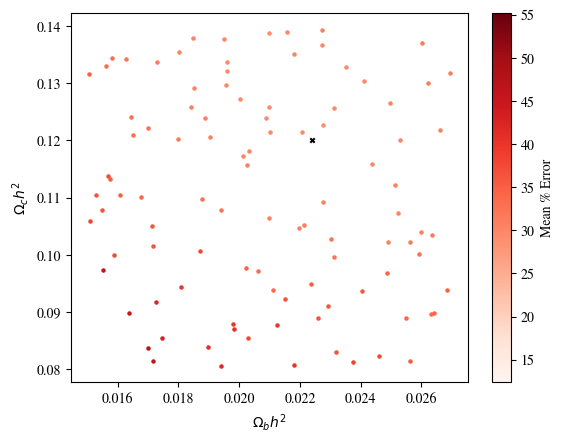

In [89]:
plot_scatter(error1)

In [90]:
def get_lensing_camb(omb, omc):
    pars = camb.set_params(H0 = 67.4, ombh2 = omb, omch2 = omc, lmax=5000)
    results = camb.get_results(pars)
    powers = results.get_cmb_power_spectra(pars, CMB_unit='muK')
    lensed = powers['total'][2:5000, 0]
    unlensed = powers['unlensed_total'][2:5000, 0]
    return lensed/unlensed

In [91]:
ombs = [0.02, 0.022, 0.022]
omcs = [0.1, 0.1, 0.12]
n = len(omcs)
#lensings_camb = [get_lensing_camb(ombs[i], omcs[i]) for i in range(n)]

In [92]:
lensings_fit = [lensing_tail_fit1(ells, ombs[i], omcs[i]) for i in range(n)]

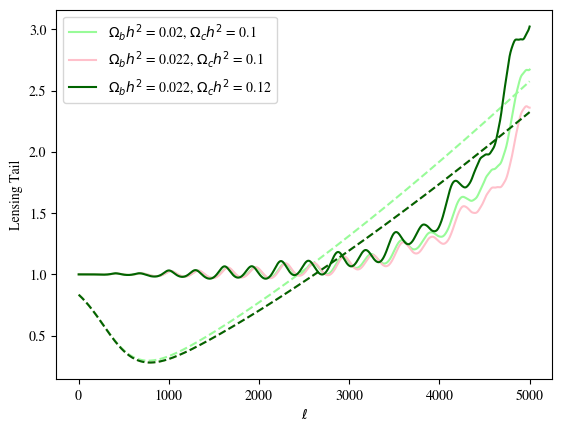

In [93]:
color_key = ["palegreen", "pink", "darkgreen"]
label_key = ["$\Omega_bh^2$ = 0.02, $\Omega_ch^2$ = 0.1", "$\Omega_bh^2$ = 0.022, $\Omega_ch^2$ = 0.1", "$\Omega_bh^2$ = 0.022, $\Omega_ch^2$ = 0.12"]
for i in range(n):
    plt.plot(ells, lensings_fit[i], color = color_key[i], linestyle = "--")
    plt.plot(ells, lensings_camb[i], color = color_key[i], label = label_key[i])
plt.xlabel("$\\ell$")
plt.ylabel("Lensing Tail")
plt.legend()